# Data Exploration 

## Import libraries
Here we import the Python modules needed for analysis

In [1]:
#Import modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
#Instruct Jupyter to show plots
%matplotlib inline

## Read in the data
Read in the CSV saved in the last step and convert the data types. 

In [12]:
#Load the saved csv file
df = pd.read_csv('GageData.csv',
                 dtype={'site_no':'str'})  #Read the site_no column as a string object

In [13]:
#Confirm it looks good by viewing the first 5 records
df.head()

,agency_cd,site_no,datetime,MeanFlow_cfs,Confidence
0,USGS,02089000,1930-10-01,210.0,A
1,USGS,02089000,1930-10-02,188.0,A
2,USGS,02089000,1930-10-03,200.0,A
3,USGS,02089000,1930-10-04,200.0,A
4,USGS,02089000,1930-10-05,200.0,A


#### Data types
Dataframes are structured so that each column contains values of a constant and defined **data type**. The various data types Pandas can use are shown here:

If we import data into a dataframe, it infers data types from the the values in the input file. We can view the datatypes in a dataframe via the dataframe's `dtypes` property:

In [5]:
#Show the data types of each column
df.dtypes

agency_cd      object
site_no         int64
datetime       object
discharge     float64
Confidence     object
dtype: object

Note that two columns have incorrectly assigned data types: The `site_no` should be a string, not a number, as it holds nominal values. Also, data

In [16]:
#Setting the date time as the index allows time slicing
df.index = df.datetime

In [17]:
#Create two new dataframes: One with records before Falls Lake an one after
dfPre = df['1950-01-01':'1979-12-31']
dfPost = df['1984-01-01':'2017-12-31']

In [18]:
#Convert datetime to an actual datetime object
df['datetime'] = pd.to_datetime(df['datetime'],format=('%Y-%m-%d'))
df.dtypes

agency_cd               object
site_no                 object
datetime        datetime64[ns]
MeanFlow_cfs           float64
Confidence              object
dtype: object

## Create scatterplots of daily discharge data
https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Python_Matplotlib_Cheat_Sheet.pdf


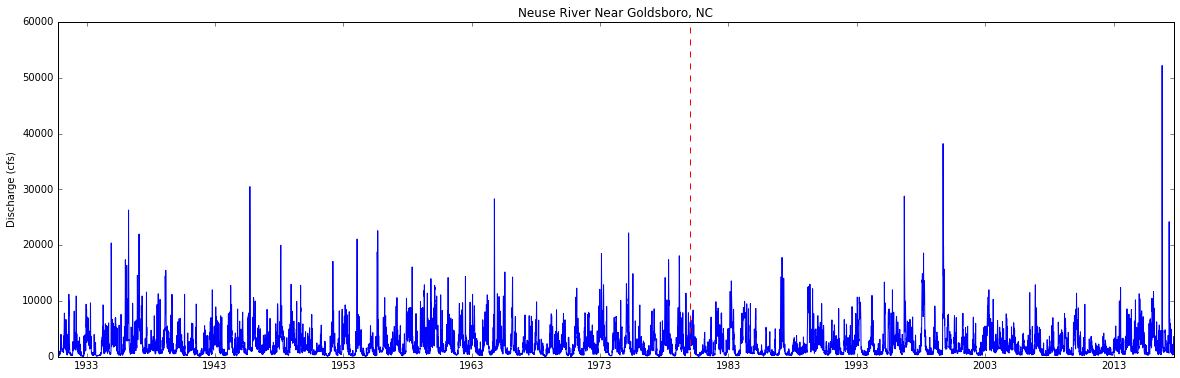

In [19]:
#Create line plots with a specified X and Y column
plt.figure(figsize=(20,6));
plt.plot(df['datetime'],df['MeanFlow_cfs']);
plt.axvline(x='1980-01-01',color='red',ls='--');
plt.title("Neuse River Near Goldsboro, NC");
plt.ylabel("Discharge (cfs)");

Use `Seaborn` to make prettier plots (more easily

https://seaborn.pydata.org/tutorial/aesthetics.html


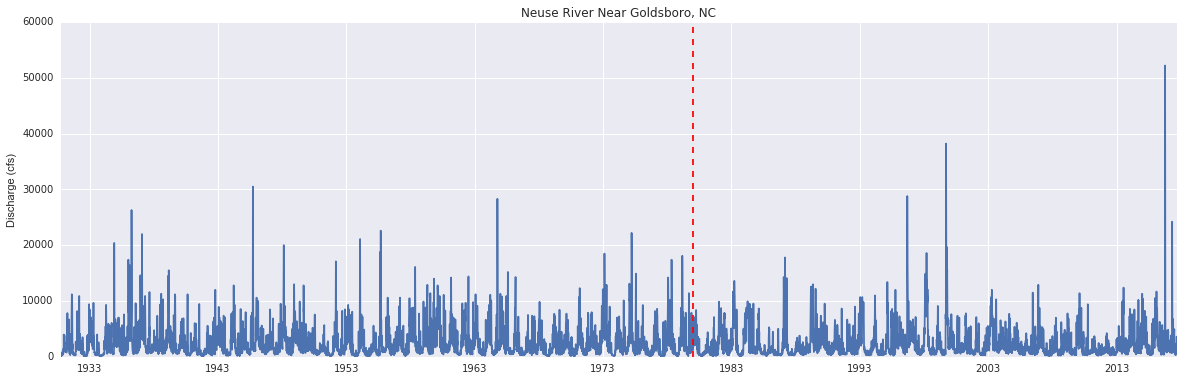

In [21]:
#Activate seaborn default aesthetics
sns.set()
#Repeat above
plt.figure(figsize=(20,6));
plt.plot(df['datetime'], df['MeanFlow_cfs']);
plt.axvline(x='1980-01-01',color='red',ls='--');
plt.title("Neuse River Near Goldsboro, NC");
plt.ylabel("Discharge (cfs)");

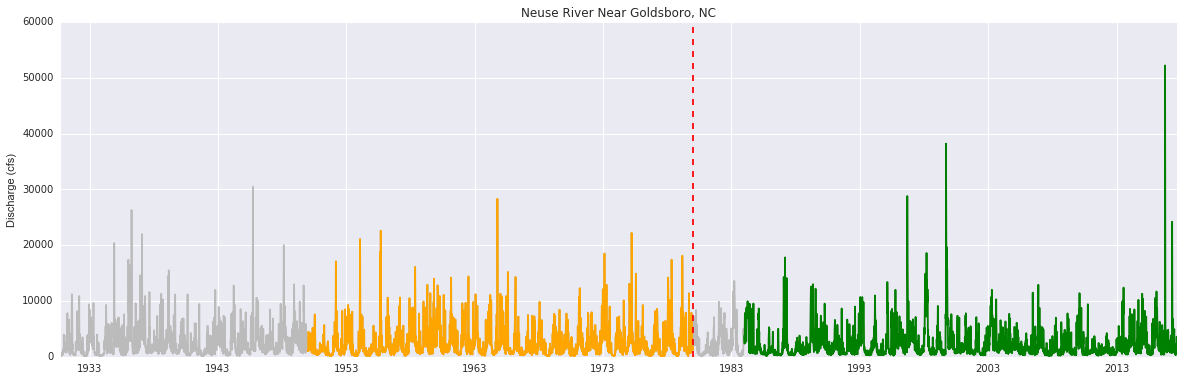

In [36]:
#And plot them too
plt.figure(figsize=(20,6));
plt.plot(df['datetime'], df['MeanFlow_cfs'],color='#BBBBBB');
plt.plot(dfPre['datetime'], dfPre['MeanFlow_cfs'],color='orange');
plt.plot(dfPost['datetime'], dfPost['MeanFlow_cfs'],color='green');
plt.axvline(x='1979-12-31',color='red',ls='--');
plt.title("Neuse River Near Goldsboro, NC");
plt.ylabel("Discharge (cfs)");

### Creating derived columns

In [25]:
#Convert from cfs to cms (1 CFS = 0.028316847 CMS)
df['MeanFlow_mps'] = df['MeanFlow_cfs'] * 0.028316847

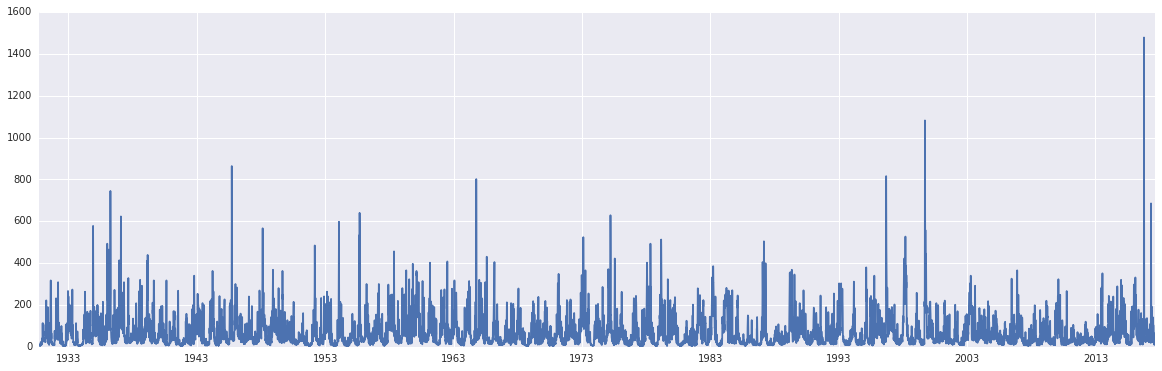

In [38]:
#Replot
plt.figure(figsize=(20,6));
plt.plot(df['datetime'],df['MeanFlow_mps']);

### Exercise: 
Convert flow in cfs to flow in million gallons per day (MGD) and replot.

In [ ]:
#Convert from csf to mgd (1 CFS = 0.53817 MGD)

In [ ]:
#Replot

### Summarize and Plot Streamflow data

In [39]:
#Get a count of all records from the dataframe's shape (rows, columns)
df.shape

(31750, 7)

In [40]:
#Or just show the rows, i.e., the first item in the shape result
df.shape[0]

31750

### Summarizing records by Confidence code
Here, we group the data by the unique values in a column, namely the `Confidence` column. First, we'll just examine the number of unique values and what those values are. 

In [43]:
#Use nunique on the column to list the number of unique values
print(df['Confidence'].nunique())

4


In [44]:
#Use unique to show what the 4 unique values are
print(df['Confidence'].unique())

['A' 'A:e' 'P' 'P:e']


Now, we'll group the records by confidence codes

In [45]:
#Create the grouped object
grpConfidence = df.groupby(['Confidence'])

In [46]:
#We can now list the counts of records by confidence code
grpConfidence.count()

,agency_cd,site_no,datetime,MeanFlow_cfs,mps,MeanFlow_mps
Confidence,,,,,,
A,31371,31371,31371,31371,31371,31371
A:e,41,41,41,41,41,41
P,336,336,336,336,336,336
P:e,2,2,2,2,2,2


In [48]:
#Or we can just show the count by a single column
grpConfidence['MeanFlow_cfs'].count()

Confidence
A      31371
A:e       41
P        336
P:e        2
Name: MeanFlow_cfs, dtype: int64

#### Plot counts by confidence code

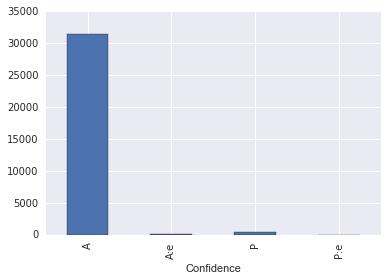

In [55]:
#https://pandas.pydata.org/pandas-docs/stable/visualization.html
count_by_Confidence = grpConfidence['MeanFlow_cfs'].count()
#count_by_Confidence.plot(kind='bar');
count_by_Confidence.plot(kind='bar');

##### Summarizing data with `Describe`

In [60]:
#Summarize the MeanFlow_cfs data, using default outputs
df['MeanFlow_cfs'].describe()

count    31750.000000
mean      2456.054110
std       2812.195361
min         78.000000
25%        662.000000
50%       1380.000000
75%       3190.000000
max      52200.000000
Name: MeanFlow_cfs, dtype: float64

In [70]:
#Summarize, using our own percentiles
sumAll = df['MeanFlow_cfs'].describe(percentiles=[0.1,0.25,0.75,0.9])
sumAll

count    31750.000000
mean      2456.054110
std       2812.195361
min         78.000000
10%        385.000000
25%        662.000000
50%       1380.000000
75%       3190.000000
90%       6180.000000
max      52200.000000
Name: MeanFlow_cfs, dtype: float64

In [81]:
#Describe records before 1980 and after 1984 (using index slicing, as above)
sumPre = dfPre['MeanFlow_cfs'].describe(percentiles=[0.1,0.25,0.75,0.9])
sumPost = dfPost['MeanFlow_cfs'].describe(percentiles=[0.1,0.25,0.75,0.9])

In [ ]:
#Concatenate (or join) the pre and post summary objects
dfSummary = pd.concat([sumAll,sumPre,sumPost],axis=1)
dfSummary.columns = ("all","before","after")

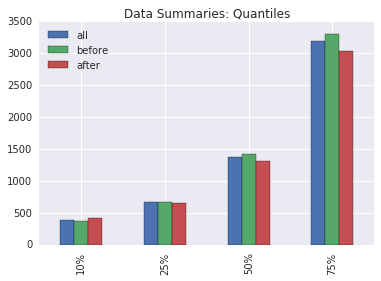

In [95]:
#https://pandas.pydata.org/pandas-docs/stable/visualization.html
#Plot
dfSummary[4:-2].plot.bar(stacked=False,
                         title="Data Summaries: Quantiles",
                         x
                        );

In [ ]:
#Box plots
dfPre['discharge'].plot(
    kind='box',
    title='My chart'
);

In [ ]:
fig = plt.figure()
ax = 
plt.plot(dfPre)

## Monthly plots

In [ ]:
df['Mo'] = df['datetime'].map(lambda x: x.month)
df.head()

In [ ]:
byMonth = df.groupby('Mo')

In [ ]:
monthlyDF = byMonth['discharge'].mean()

In [ ]:
monthlyDF

In [ ]:
plt.plot(monthlyDF,);